In [121]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pyfits
import plotc
import read_params
np.set_printoptions(precision=3)
import scipy.integrate, scipy.interpolate, scipy.fftpack, scipy.special
import dbyd2
import matplotlib.ticker
%load_ext Cython

def fitsread(f): return np.squeeze(pyfits.getdata(f)).byteswap().newbyteorder()

Lx=read_params.get_xlength()
nx=read_params.get_nx()
x=np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
z,c,rho,p,g,gamma=np.loadtxt(read_params.get_solarmodel(),usecols=range(6),unpack=True)
Rsun = 6.95989467700E2
z=(z-1)*Rsun

def two_d(a): return a[:,np.newaxis]

c = two_d(c)
rho = two_d(rho)
p = two_d(p)
g = two_d(g)
gamma = two_d(gamma)

c = c/100 # Convert to m/s

def ind_x(x): return int((x/Lx+1/2)*nx)
def ind_z(z_coord): return abs(z-z_coord).argmin()

z_surf=ind_z(0)

dbyd2_z = np.zeros((1,)+z.shape,order='F')
dbyd2.dbyd2(dbyd2_z,np.asfortranarray(np.atleast_2d(z)),1)

def ddz(arr):
    arr = np.asfortranarray(arr).T
    numerator = np.zeros(arr.shape,order='F')
    dbyd2.dbyd2(numerator,arr,1)
    return (numerator/dbyd2_z).T

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


### Density and sound-speed near surface

/home/jishnu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


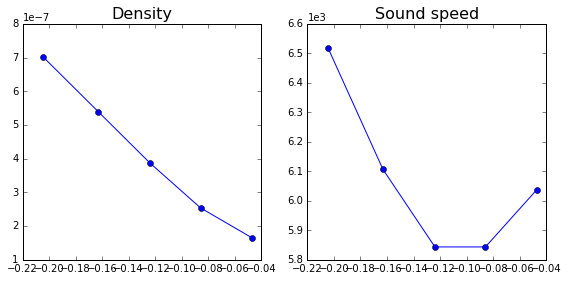

In [4]:
z_left = -0.2; z_right = 0.0

plt.subplot(121)
plt.plot(z[ind_z(z_left):ind_z(z_right)],rho[ind_z(z_left):ind_z(z_right),0],'-o')
plt.ticklabel_format(style="sci",scilimits=(0,0),axis="y")
plt.title("Density",fontsize=16)

plt.subplot(122)
plt.plot(z[ind_z(z_left):ind_z(z_right)],c[ind_z(z_left):ind_z(z_right),0],'-o')
plt.ticklabel_format(style="sci",scilimits=(0,0),axis="y")
plt.title("Sound speed",fontsize=16)

plt.gcf().set_size_inches(8,4)
plt.tight_layout()

## Velocity and vector potential

The vector potential is defined as 

$$ \psi = \frac{v_{0}}{c\left(z\right)}\frac{\mathrm{sign}\left(x\right)}{k}\,J_{1}\left(k\left|x\right|\right)\exp\left(-\frac{\left(z-z_{0}\right)^{2}}{2\sigma_{z}^{2}}-\frac{\left|x\right|}{R}\right)+\psi_{0}^{\mathrm{ref}} $$

Velocity components are defined as 


$$ \begin{eqnarray*}
\mathbf{v} & = & \frac{1}{\rho}\nabla\left(\rho c\psi\right)\\
v_{x} & = & -\frac{1}{\rho}\partial_{z}\left(\rho c\psi\right)\\
v_{z} & = & \frac{1}{\rho}\partial_{x}\left(\rho c\psi\right)\\
 & = & \partial_{x}\psi
\end{eqnarray*} $$

Evaluating the derivatives analytically we obtain 

$$ \begin{eqnarray*}
v_{x} & = & v_{0}\left[\frac{\mathrm{sign}\left(x\right)}{k}\,J_{1}\left(k\left|x\right|\right)\exp\left(-\frac{\left|x\right|}{R}\right)\right]\left(\frac{\left(z-z_{0}\right)}{\sigma_{z}^{2}}-\frac{\rho^{\prime}\left(z\right)}{\rho\left(z\right)}\right)\exp\left(-\frac{\left(z-z_{0}\right)^{2}}{2\sigma_{z}^{2}}\right),\\
v_{z} & = & v_{0}\left[\left(\frac{1}{2}\left(J_{0}\left(k\left|x\right|\right)-J_{2}\left(k\left|x\right|\right)\right)-\frac{1}{kR}J_{1}\left(k\left|x\right|\right)\right)\exp\left(-\frac{\left|x\right|}{R}\right)\right]\exp\left(-\frac{\left(z-z_{0}\right)^{2}}{2\sigma_{z}^{2}}\right).
\end{eqnarray*}$$

#### Define parameters

$ v_{0}=240\,\mathrm{ms^{-1}}
 , k=2\pi/30\,\mathrm{rad\,Mm^{-1}}
 , R=15\,\mathrm{Mm}
 , z_{0}=-2.3\,\mathrm{Mm}
  \;\mathrm{and}\; \sigma_{z}=0.912\,\mathrm{Mm} $ 

In [5]:
v0 = 240; k=2*np.pi/30; R=15; z0=-2.3; sigmaz = 0.912

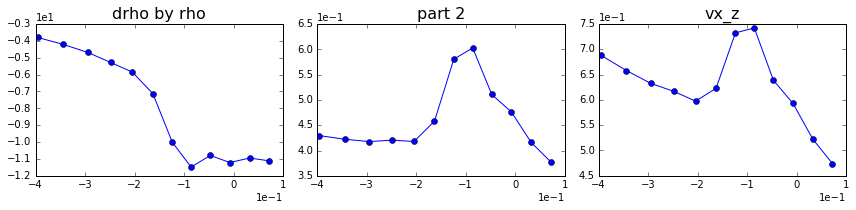

In [7]:
drho_by_rho = ddz(rho).flatten()/rho.flatten()

vx_z = ((z-z0)/sigmaz**2 - drho_by_rho)*np.exp(-(z-z0)**2/(2*sigmaz**2))
vx_z_1 = (z-z0)/sigmaz**2*np.exp(-(z-z0)**2/(2*sigmaz**2))
vx_z_2 = -drho_by_rho*np.exp(-(z-z0)**2/(2*sigmaz**2))

z_left = -0.4; z_right = 0.1

def surface(arr): return arr[ind_z(z_left):ind_z(z_right)]

gl=plotc.gridlist(1,3)

plt.subplot(next(gl))
plt.plot(surface(z),surface(drho_by_rho),'-o')
plt.title("drho by rho",fontsize=16)
plt.ticklabel_format(style="sci",scilimits=(0,0))

plt.subplot(next(gl))
plt.plot(surface(z),surface(vx_z_2),'-o')
plt.title("part 2",fontsize=16)
plt.ticklabel_format(style="sci",scilimits=(0,0))

plt.subplot(next(gl))
plt.plot(surface(z),surface(vx_z),'-o');
plt.title("vx_z",fontsize=16)
plt.ticklabel_format(style="sci",scilimits=(0,0))

plt.gcf().set_size_inches(12,3)
plt.tight_layout()

What's up with $d\rho/\rho$?

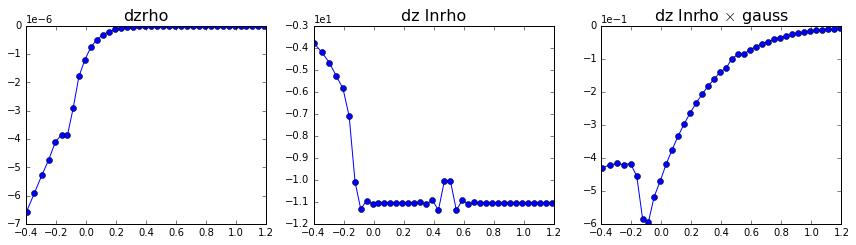

In [148]:
plt.subplot(131)
drho = ddz(rho).flatten()
dlnrho = ddz(np.log(rho)).flatten()

left_ind = 260

plt.plot(z[left_ind:],drho[left_ind:],'-o');
plt.ticklabel_format(style="sci",scilimits=(0,0))
plt.title("dzrho",fontsize=16)

plt.subplot(132)
plt.plot(z[left_ind:],dlnrho[left_ind:],'-o');
plt.ticklabel_format(style="sci",scilimits=(0,0))
plt.title("dz lnrho",fontsize=16)

plt.subplot(133)
dlnrho_gaussian = dlnrho*np.exp(-(z-z0)**2/(2*sigmaz**2))

plt.plot(z[left_ind:],dlnrho_gaussian[left_ind:],'-o');
plt.ticklabel_format(style="sci",scilimits=(0,0))
plt.title(r"dz lnrho $\times$ gauss",fontsize=16)

plt.gcf().set_size_inches(12,3.5)
plt.tight_layout()

Let us smooth dz rho

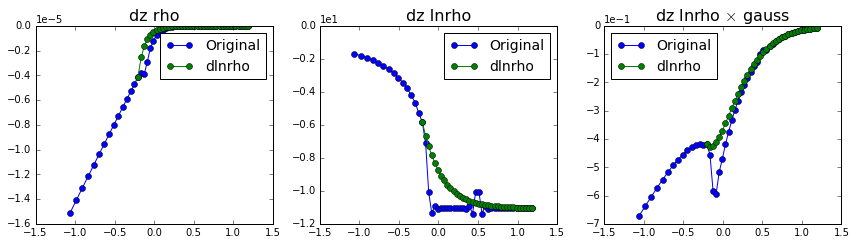

In [227]:
# z_left_1 = -0.8; z_right_1 = -0.2; z_left_2 = -0; z_right_2 = z[-1]
# def lr(arr):
#     arr_left = arr[ind_z(z_left_1):ind_z(z_right_1)]
#     arr_right = arr[ind_z(z_left_2):ind_z(z_right_2)]
#     return np.concatenate((arr_left,arr_right))

# s = scipy.interpolate.InterpolatedUnivariateSpline(lr(z),lr(drho))

# drho_smoothed_surf = s(surface(z))
# drho_smoothed = np.concatenate((drho[:ind_z(z_left_1)],s(z[ind_z(z_left_1):])))
# drho_smoothed = two_d(drho_smoothed)

left_ind = 250
left_ind_fit = 264
slope_left = (dlnrho[left_ind_fit+1]-dlnrho[left_ind_fit-1])/(z[left_ind_fit+1]-z[left_ind_fit-1])
z_left = z[left_ind_fit]
asymptotic_const = np.mean(dlnrho[-5:])

# rho from exponential fit to dz ln rho
yl_minus_yasymp = dlnrho[left_ind_fit]-asymptotic_const
dlnrho_smoothed_from_dlnrho = ((yl_minus_yasymp*np.exp(slope_left*(z[left_ind_fit:]-z_left)/yl_minus_yasymp)) 
                            + asymptotic_const)
dlnrho_smoothed_from_dlnrho = two_d(np.concatenate((dlnrho[:left_ind_fit],dlnrho_smoothed_from_dlnrho)))

rho_smoothed_from_dlnrho = (rho[left_ind_fit,0]*np.exp(asymptotic_const*(z[left_ind_fit:]-z_left))*
                         np.exp(yl_minus_yasymp**2/slope_left*
                                (np.exp(slope_left/yl_minus_yasymp*(z[left_ind_fit:]-z_left))-1)))
rho_smoothed_from_dlnrho = two_d(np.concatenate((rho[:left_ind_fit,0],rho_smoothed_from_dlnrho)))

drho_smoothed_from_dlnrho = rho[left_ind_fit,0]*np.exp(asymptotic_const*(z[left_ind_fit:]-z_left))*(asymptotic_const+
                         np.exp(yl_minus_yasymp**2/slope_left*
                                (np.exp(slope_left/yl_minus_yasymp*(z[left_ind_fit:]-z_left))-1))*
                                    yl_minus_yasymp*np.exp(slope_left/yl_minus_yasymp*(z[left_ind_fit:]-z_left)))
drho_smoothed_from_dlnrho = two_d(np.concatenate((drho[:left_ind_fit],drho_smoothed_from_dlnrho)))

# rho from exponential fit to dzrho, not useful
# left_ind_fit_2 = 266
# slope_left = (drho[left_ind_fit_2+1]-drho[left_ind_fit_2-1])/(z[left_ind_fit_2+1]-z[left_ind_fit_2-1])
# asymptotic_const = np.mean(drho[-5:])
# yl_minus_yasymp = drho[left_ind_fit_2]-asymptotic_const
# z_left = z[left_ind_fit_2]
# drho_smoothed_from_drho = ((yl_minus_yasymp*np.exp(slope_left*(z[left_ind_fit_2:]-z_left)/yl_minus_yasymp)) 
#                             + asymptotic_const)

# rho_smoothed_from_drho = (rho[left_ind_fit_2,0]+asymptotic_const*(z[left_ind_fit_2:]-z_left)+
#                           yl_minus_yasymp**2/slope_left*
#                           (np.exp(slope_left/yl_minus_yasymp*(z[left_ind_fit_2:]-z_left))-1))

# dlnrho_smoothed_from_drho = drho_smoothed_from_drho/rho_smoothed_from_drho

# drho_smoothed_from_drho = two_d(np.concatenate((drho[:left_ind_fit_2],drho_smoothed_from_drho)))
# rho_smoothed_from_drho = two_d(np.concatenate((rho[:left_ind_fit_2,0],rho_smoothed_from_drho)))
# dlnrho_smoothed_from_drho = two_d(np.concatenate((dlnrho[:left_ind_fit_2],dlnrho_smoothed_from_drho)))

plt.subplot(131)
plt.plot(z[left_ind:],drho[left_ind:],'-o',label="Original");
plt.plot(z[left_ind_fit:],drho_smoothed_from_dlnrho[left_ind_fit:,0],'-o',label="dlnrho");
# plt.plot(z[left_ind_fit_2:],drho_smoothed_from_drho[left_ind_fit_2:,0],'-o',label="drho");
plt.title("dz rho",fontsize=16)
plt.legend(loc="best",fontsize=14);
plt.ticklabel_format(style="sci",scilimits=(0,0))

plt.subplot(132)
plt.plot(z[left_ind:],dlnrho[left_ind:],'-o',label="Original");
plt.plot(z[left_ind_fit:],dlnrho_smoothed_from_dlnrho[left_ind_fit:,0],'-o',label="dlnrho");
# plt.plot(z[left_ind_fit_2:],dlnrho_smoothed_from_drho[left_ind_fit_2:,0],'-o',label="drho");
plt.title("dz lnrho",fontsize=16)
plt.legend(loc="best",fontsize=14);
plt.ticklabel_format(style="sci",scilimits=(0,0))

plt.subplot(133)
plt.plot(z[left_ind:],dlnrho_gaussian[left_ind:],'-o',label="Original");
plt.plot(z[left_ind_fit:],dlnrho_smoothed_from_dlnrho[left_ind_fit:,0]*np.exp(-(z[left_ind_fit:]-z0)**2/(2*sigmaz**2))
         ,'-o',label="dlnrho");
# plt.plot(z[left_ind_fit_2:],(dlnrho_smoothed_from_drho[left_ind_fit_2:,0]*
#                              np.exp(-(z[left_ind_fit_2:]-z0)**2/(2*sigmaz**2)))
#          ,'-o',label="drho");
plt.title(r"dz lnrho $\times$ gauss",fontsize=16)
plt.legend(loc="best",fontsize=14);
plt.ticklabel_format(style="sci",scilimits=(0,0))

plt.gcf().set_size_inches(12,3.5)
plt.tight_layout()

We would want to enforce hydrostatic balance, so pressure is to be computed from density through
$$ \begin{eqnarray*}
\frac{dp}{dz} & = & -\rho g\\
p & = & p\left(z_{0}\right)-\int_{z_{0}}^{z}dz\,\rho g
\end{eqnarray*}$$

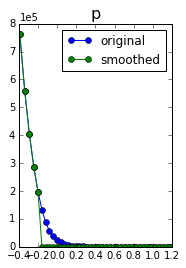

In [246]:
from scipy.integrate import cumtrapz
p_smoothed_hydrostatic = np.concatenate((p[:left_ind_fit],
                             cumtrapz((rho_smoothed_from_dlnrho*g)[left_ind_fit:],
                                      x=z[left_ind_fit:],initial=p[left_ind_fit,0],axis=0)))
plt.subplot(next(gl))
plt.plot(z[left_ind:],p[left_ind:,0],'o-',label="original")
plt.plot(z[left_ind:],p_smoothed_hydrostatic[left_ind:,0],'o-',label="smoothed")
plt.axhline(0,ls="dotted",color="black")
plt.ticklabel_format(style="sci",scilimits=(0,0));
plt.title("p",fontsize=16)
plt.legend(loc="best")

## d(lnp)/dz

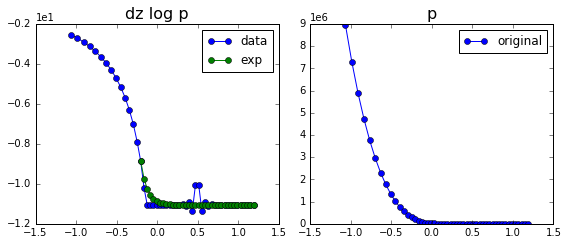

In [210]:
left_ind = 250
left_ind_fit = 264
dlnp = ddz(np.log(p)).flatten()
slope_left = (dlnp[left_ind_fit+1]-dlnp[left_ind_fit-1])/(z[left_ind_fit+1]-z[left_ind_fit-1])
z_left = z[left_ind_fit]
asymptotic_const = np.mean(dlnp[-5:])

yl_minus_yasymp = dlnp[left_ind_fit]-asymptotic_const
dlnp_smoothed = ((yl_minus_yasymp*np.exp(slope_left*(z[left_ind_fit:]-z_left)/yl_minus_yasymp)) 
                            + asymptotic_const)
dlnp_smoothed = two_d(np.concatenate((dlnp[:left_ind_fit],dlnp_smoothed)))

gl=plotc.gridlist(1,2)

plt.subplot(next(gl))
plt.plot(z[left_ind:],dlnp[left_ind:],'o-',label="data");
plt.plot(z[left_ind_fit:],dlnp_smoothed[left_ind_fit:],'o-',label="exp")
plt.ticklabel_format(style="sci",scilimits=(0,0));
plt.title("dz log p",fontsize=16)
plt.legend();

plt.subplot(next(gl))
plt.plot(z[left_ind:],p[left_ind:,0],'o-',label="original")
plt.axhline(0,ls="dotted",color="black")
plt.ticklabel_format(style="sci",scilimits=(0,0));
plt.title("p",fontsize=16)
plt.legend(loc="best")

plt.gcf().set_size_inches(8,3.5)
plt.tight_layout()

## Brunt-Väisälä Frequency

We need to ensure convective stability, that is a positive Brunt-Väisälä frequency. It is defined as 

$$
\begin{eqnarray*}
N^{2} & = & g_{0}\left(\frac{1}{\Gamma_{1,0}}\frac{d\ln p_{0}}{dr}-\frac{d\ln\rho_{0}}{dr}\right)\\
\frac{N^{2}}{g_{0}} & = & \frac{1}{\Gamma_{1,0}}\frac{d\ln p_{0}}{dr}-\frac{d\ln\rho_{0}}{dr}
\end{eqnarray*}
$$

original min N2 -0.0284054951113 at index 264 z -0.204377970092
modified min N2 -0.0284054951113 at index 264 z -0.204377970092


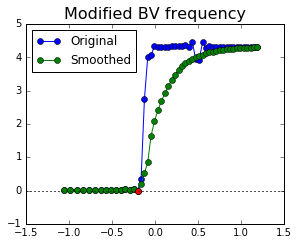

In [230]:
gl = plotc.gridlist(1,2)

plt.subplot(next(gl))
# Original BV frequency
N2_by_g = ddz(np.log(p))/gamma - ddz(np.log(rho))
plt.plot(z[250:],N2_by_g[250:],'o-',label="Original");
plt.axhline(0,ls="dotted",color="0.1")
plt.ticklabel_format(style="sci",scilimits=(0,0));
plt.title("BV frequency",fontsize=16)
print "original min N2",N2_by_g.min(),"at index",N2_by_g.argmin(),"z",z[N2_by_g.argmin()]

# modified BV frequency
N2_by_g_mod = dlnp_smoothed_exp/gamma - dlnrho_smoothed_from_dlnrho
plt.plot(z[250:],N2_by_g_mod[250:],'o-',label="Smoothed");
plt.plot(z[left_ind_fit:left_ind_fit+1],N2_by_g_mod[left_ind_fit:left_ind_fit+1],'ro');
plt.axhline(0,ls="dotted",color="0.1")
plt.ticklabel_format(style="sci",scilimits=(0,0));
plt.title("Modified BV frequency",fontsize=16)
print "modified min N2",N2_by_g_mod.min(),"at index",N2_by_g_mod.argmin(),"z",z[N2_by_g_mod.argmin()]

plt.legend(loc="best")
plt.gcf().set_size_inches(8,3.5);
plt.tight_layout()

## Hydrostatic balance

## Sound speed

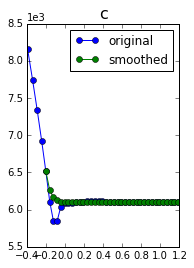

In [240]:
gl=plotc.gridlist(1,2)

left_ind = 260
left_ind_fit = 264
slope_left = (c[left_ind_fit+1,0]-c[left_ind_fit-1,0])/(z[left_ind_fit+1]-z[left_ind_fit-1])
z_left = z[left_ind_fit]
asymptotic_const = np.mean(c[-5:,0])

yl_minus_yasymp = c[left_ind_fit,0]-asymptotic_const
c_smoothed = ((yl_minus_yasymp*np.exp(slope_left*(z[left_ind_fit:]-z_left)/yl_minus_yasymp)) 
                            + asymptotic_const)
c_smoothed = two_d(np.concatenate((c[:left_ind_fit,0],c_smoothed)))


plt.subplot(next(gl))
plt.plot(z[left_ind:],c[left_ind:],'o-',label="original");
plt.plot(z[left_ind_fit:],c_smoothed[left_ind_fit:],'o-',label="smoothed");
plt.ticklabel_format(style="sci",scilimits=(0,0));
plt.title("c",fontsize=16)
plt.legend();

In [243]:
np.savetxt('solar_deep_smoothed',np.hstack((z[:,None],c_smoothed,rho_smoothed_from_dlnrho,p_smoothed,g,gamma)))